In [1]:
# =========================
# 1. Import کتابخانه‌ها
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

from statsmodels.robust.scale import huber


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# =========================
# 2. بارگذاری داده
# =========================
df = pd.read_csv("all_stocks_5yr.csv")
df['date'] = pd.to_datetime(df['date'])
df = df[(df['date'] >= "2013-01-01") & (df['date'] <= "2018-12-31")]

# انتخاب 50 سهم برتر براساس میانگین حجم معاملات
stock_stats = df.groupby("Name").agg(
    days_traded=("date", "count"),
    avg_volume=("volume", "mean")
).reset_index()
top50_stocks = stock_stats.sort_values("avg_volume", ascending=False).head(50)["Name"].tolist()

# =========================
# Robust با Huber
# =========================
def huber_series(prices, window=4):
    robust_vals = []
    for i in range(len(prices) - window + 1):
        mu, scale = huber(prices[i:i+window])
        robust_vals.append(mu)
    return np.array(robust_vals)

# ساخت sequence برای قیمت
def create_sequences(data, window=8):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# SMAPE امن
EPS = 1e-8
def safe_smape(y_true, y_pred):
    num = 2.0 * np.abs(y_pred - y_true)
    den = np.abs(y_pred) + np.abs(y_true) + EPS
    return np.mean(num / den) * 100.0

# آماده‌سازی داده روی Close robust
WINDOW = 8
stock_data_prices = {}
for name in top50_stocks:
    stock_prices = df[df['Name'] == name].sort_values("date")['close'].values.astype(float)
    robust_prices = huber_series(stock_prices, window=4).reshape(-1,1)
    
    # Scaling فقط روی train
    split_idx = int(len(robust_prices) * 0.8)
    scaler = MinMaxScaler(feature_range=(0,1))
    prices_scaled = np.zeros_like(robust_prices, dtype=float)
    prices_scaled[:split_idx] = scaler.fit_transform(robust_prices[:split_idx])
    prices_scaled[split_idx:] = scaler.transform(robust_prices[split_idx:])
    
    X, y = create_sequences(prices_scaled.flatten(), window=WINDOW)
    stock_data_prices[name] = (X, y, scaler)

print("✅ آماده‌سازی داده روی Close robust انجام شد.")


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\robust\scale.py:292: RuntimeWarning: divide by zero encountered in divide
  subset = np.less_equal(np.abs((a - mu) / scale), self.c)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\robust\scale.py:292: RuntimeWarning: invalid value encountered in divide
  subset = np.less_equal(np.abs((a - mu) / scale), self.c)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\robust\scale.py:292: RuntimeWarning: divide by zero encountered in divide
  subset = np.less_equal(np.abs((a - mu) / scale), self.c)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\robust\scale.py:292: RuntimeWarning: invalid value encountered in divide
  subset = np.less_equal(np.abs((a - mu) / scale), self.c)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\robust\scale.py:292: RuntimeWarning: divide by zer

✅ آماده‌سازی داده روی Close robust انجام شد.


In [3]:

# =========================
# 3. مدل‌ها
# =========================
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, activation="tanh", input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss="mse", metrics=["mae"])
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, activation="tanh"), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss="mse", metrics=["mae"])
    return model

def build_cnn_bilstm(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation="relu", padding="same", input_shape=input_shape),
        Bidirectional(LSTM(64, activation="tanh")),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss="mse", metrics=["mae"])
    return model



In [4]:
# =========================
# 4. آموزش و ارزیابی (بازنویسی‌شده + tqdm)
# =========================
from tqdm.auto import tqdm  # 👈 این خط اضافه شد

def train_and_evaluate(model_name, build_fn):
    results = []
    predictions = {}   # 👈 برای ذخیره y_test و y_pred هر سهم

    outer_bar = tqdm(
        enumerate(top50_stocks, 1),
        total=len(top50_stocks),
        desc=f"Training {model_name}",
        unit="stock"
    )

    for idx, name in outer_bar:
        outer_bar.set_postfix_str(name)

        X, y, scaler = stock_data_prices[name]
        X = X.reshape((X.shape[0], X.shape[1], 1))

        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        model = build_fn(X_train.shape[1:])
        es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

        # نوار پیشرفتِ هر اپک/بچ با TqdmCallback
        history = model.fit(
            X_train, y_train,
            epochs=30, batch_size=64,
            validation_split=0.1,
            verbose=0,
            callbacks=[TqdmCallback(verbose=2), es]
        )

        # پیش‌بینی
        y_pred = model.predict(X_test, verbose=0).flatten()

        # برگرداندن به مقیاس اصلی
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
        y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()

        # متریک‌ها
        mae = mean_absolute_error(y_test_inv, y_pred_inv)
        mse = mean_squared_error(y_test_inv, y_pred_inv)
        smape = safe_smape(y_test_inv, y_pred_inv)
        results.append([name, model_name, mae, mse, smape])

        # 👈 ذخیره پیش‌بینی‌ها
        predictions[name] = {
            "y_test": y_test_inv,
            "y_pred": y_pred_inv
        }

        # نمایش خلاصه متریک‌ها روی نوار پیشرفت بیرونی
        outer_bar.set_postfix(MAE=f"{mae:.3f}", MSE=f"{mse:.3f}", SMAPE=f"{smape:.2f}%")

    results_df = pd.DataFrame(results, columns=["Stock","Model","MAE","MSE","SMAPE"])
    return results_df, predictions


In [5]:
results_lstm, preds_lstm = train_and_evaluate("LSTM", build_lstm)
results_bilstm, preds_bilstm = train_and_evaluate("BiLSTM", build_bilstm)
results_cnn_bilstm, preds_cnn_bilstm = train_and_evaluate("CNN+BiLSTM", build_cnn_bilstm)

# نتایج متریک‌ها
all_results = pd.concat([results_lstm, results_bilstm, results_cnn_bilstm])
avg_results = all_results.groupby("Model")[["MAE","MSE","SMAPE"]].mean().reset_index()

print("📊 Average performance across models (Close price robust):")
print(avg_results)


Training LSTM:   0%|          | 0/50 [00:00<?, ?stock/s, BAC]

100%|██████████| 15.0/15.0 [00:01<00:00, 7.62batch/s, loss=0.0402, mae=0.158]

100%|██████████| 15.0/15.0 [00:00<00:00, 130batch/s, loss=0.00549, mae=0.0622]


100%|██████████| 15.0/15.0 [00:00<00:00, 108batch/s, loss=0.00295, mae=0.0451]

100%|██████████| 15.0/15.0 [00:00<00:00, 127batch/s, loss=0.0017, mae=0.0319]

100%|██████████| 15.0/15.0 [00:00<00:00, 141batch/s, loss=0.00137, mae=0.0293]

100%|██████████| 15.0/15.0 [00:00<00:00, 105batch/s, loss=0.00113, mae=0.0256]

100%|██████████| 15.0/15.0 [00:00<00:00, 130batch/s, loss=0.000995, mae=0.0236]


100%|██████████| 15.0/15.0 [00:00<00:00, 91.1batch/s, loss=0.000922, mae=0.0227]

100%|██████████| 15.0/15.0 [00:00<00:00, 131batch/s, loss=0.000901, mae=0.0224]

100%|██████████| 15.0/15.0 [00:00<00:00, 134batch/s, loss=0.000885, mae=0.0222]


100%|██████████| 15.0/15.0 [00:00<00:00, 106batch/s, loss=0.000882, mae=0.0221]

100%|██████████| 15.0/15.0 [00:00<00:00, 134batch/

📊 Average performance across models (Close price robust):
        Model       MAE       MSE     SMAPE
0      BiLSTM  1.051712  5.249904  2.041377
1  CNN+BiLSTM  1.053482  4.849297  2.052011
2        LSTM  1.226792  8.564155  2.240450


C:\Users\User\AppData\Local\Temp\ipykernel_56992\1740905254.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=avg_results, ax=axes[i], palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_56992\1740905254.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=avg_results, ax=axes[i], palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_56992\1740905254.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y=metric, data=avg_results, ax=axes[i], palette="viridis"

📊 Average performance across models (Close price robust):
        Model       MAE       MSE     SMAPE
0      BiLSTM  1.051712  5.249904  2.041377
1  CNN+BiLSTM  1.053482  4.849297  2.052011
2        LSTM  1.226792  8.564155  2.240450


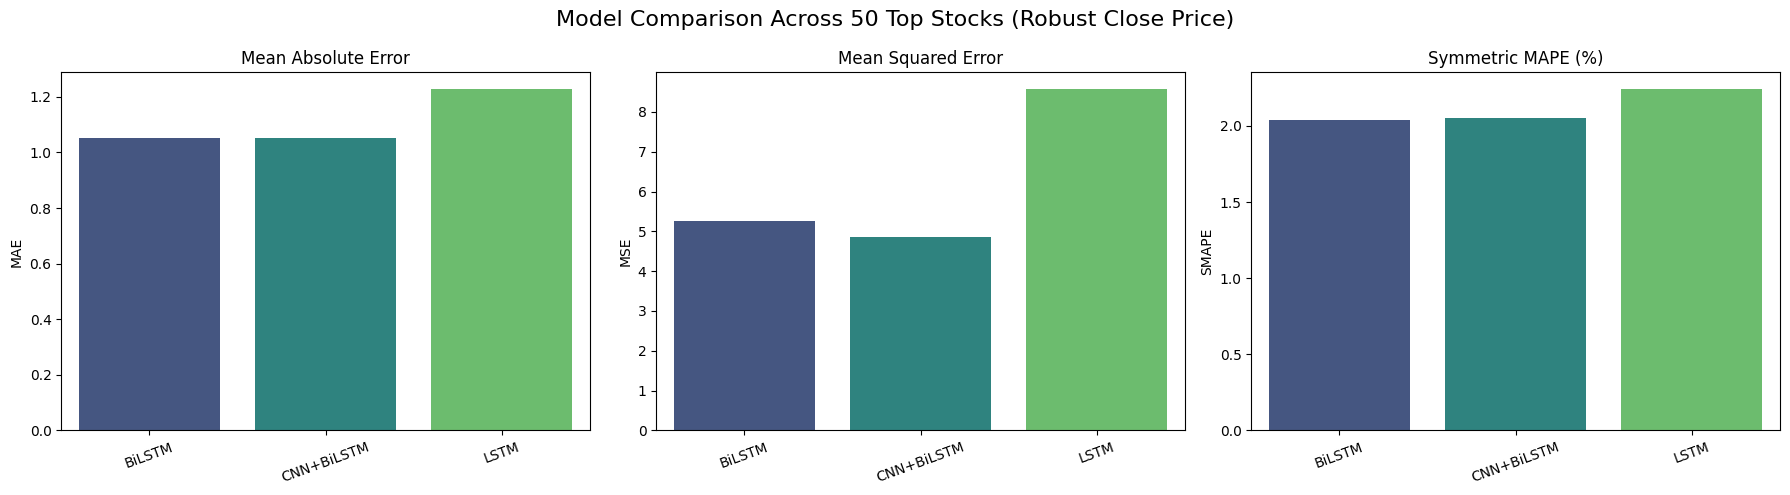

In [6]:

# =========================
# 5. مقایسه نهایی
# =========================
all_results = pd.concat([
    results_lstm,
    results_bilstm,
    results_cnn_bilstm,
    
])

avg_results = all_results.groupby("Model")[["MAE","MSE","SMAPE"]].mean().reset_index()

print("📊 Average performance across models (Close price robust):")
print(avg_results)

# نمودار
fig, axes = plt.subplots(1, 3, figsize=(18,5))
metrics = ["MAE","MSE","SMAPE"]
titles = ["Mean Absolute Error","Mean Squared Error","Symmetric MAPE (%)"]

for i, metric in enumerate(metrics):
    sns.barplot(x="Model", y=metric, data=avg_results, ax=axes[i], palette="viridis")
    axes[i].set_title(titles[i])
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=20)

plt.suptitle("Model Comparison Across 50 Top Stocks (Robust Close Price)", fontsize=16)
plt.tight_layout()
plt.show()

In [31]:
# =========================
# بازده 21 روزه بر اساس بازه‌های تست (نسخه اصلاح‌شده)
# =========================
period = 21
n_periods = 10

all_periods = []

for i in range(n_periods):
    tmp_returns = []
    
    for name in top50_stocks:
        y_test_inv = preds_lstm[name]["y_test"]
        y_pred_inv = preds_lstm[name]["y_pred"]
        
        real_r = compute_period_return(y_test_inv, start=i*period, period=period)
        pred_r = compute_period_return(y_pred_inv, start=i*period, period=period)

        if real_r is not None and pred_r is not None:
            # تاریخ‌ها
            stock_dates = df[df["Name"] == name].sort_values("date")["date"].values
            split_idx = int(len(stock_dates) * 0.8)
            test_dates = stock_dates[WINDOW+split_idx:]  # به خاطر sequence

            # اطمینان از کافی بودن طول
            if (i*period + period) < len(test_dates):
                start_date = pd.to_datetime(test_dates[i*period]).date()
                end_date   = pd.to_datetime(test_dates[i*period + period]).date()

                tmp_returns.append([name, real_r, pred_r, start_date, end_date])
    
    # انتخاب 10 سهم برتر در همین بازه
    if len(tmp_returns) > 0:
        tmp_df = pd.DataFrame(tmp_returns, columns=["Stock","Real_Return","Pred_Return","Start_Date","End_Date"])
        tmp_df = tmp_df.sort_values("Real_Return", ascending=False).head(10)
        tmp_df["Period"] = i+1
        all_periods.append(tmp_df)

# ادغام همه بازه‌ها
returns_df = pd.concat(all_periods).reset_index(drop=True)


NameError: name 'compute_period_return' is not defined

In [ ]:
# =========================
# تابع بازده بازه‌ای
# =========================
def compute_period_return(prices, start=0, period=21):
    """
    محاسبه بازده درصدی بین start و start+period
    prices: آرایه قیمتها
    start: نقطه شروع
    period: طول بازه (مثلا 21 روز معاملاتی)
    """
    if start + period < len(prices):
        p0 = prices[start]
        p1 = prices[start + period]
        if p0 != 0:
            return ((p1 - p0) / p0) * 100   # بازده درصدی
    return None


# =========================
# بازده 21 روزه بر اساس بازه‌های تست
# =========================
period = 21
n_periods = 10

all_periods = []

for i in range(n_periods):
    tmp_returns = []
    
    for name in top50_stocks:
        y_test_inv = preds_lstm[name]["y_test"]
        y_pred_inv = preds_lstm[name]["y_pred"]
        
        real_r = compute_period_return(y_test_inv, start=i*period, period=period)
        pred_r = compute_period_return(y_pred_inv, start=i*period, period=period)

        if real_r is not None and pred_r is not None:
            # تاریخ‌ها
            stock_dates = df[df["Name"] == name].sort_values("date")["date"].values
            split_idx = int(len(stock_dates) * 0.8)
            test_dates = stock_dates[WINDOW+split_idx:]  # به خاطر sequence

            # اطمینان از کافی بودن طول
            if (i*period + period) < len(test_dates):
                start_date = pd.to_datetime(test_dates[i*period]).date()
                end_date   = pd.to_datetime(test_dates[i*period + period]).date()

                tmp_returns.append([name, real_r, pred_r, start_date, end_date])
    
    # انتخاب 10 سهم برتر در همین بازه
    if len(tmp_returns) > 0:
        tmp_df = pd.DataFrame(tmp_returns, columns=["Stock","Real_Return","Pred_Return","Start_Date","End_Date"])
        tmp_df = tmp_df.sort_values("Real_Return", ascending=False).head(10)
        tmp_df["Period"] = i+1
        all_periods.append(tmp_df)

# ادغام همه بازه‌ها
returns_df = pd.concat(all_periods).reset_index(drop=True)

print("✅ محاسبه بازده‌ ۲۱ روزه برای همه بازه‌ها انجام شد.")


✅ محاسبه بازده‌ ۲۱ روزه برای همه بازه‌ها انجام شد.


In [35]:
# =========================
# 1. محاسبه بازده روزانه سهم‌ها در تست
# =========================
daily_returns = {}

for name in top50_stocks:
    y_test_inv = preds_lstm[name]["y_test"]  # قیمت‌های واقعی تست
    # بازده روزانه (درصدی)
    dr = (pd.Series(y_test_inv).pct_change().dropna() * 100).values
    daily_returns[name] = dr

# =========================
# 2. محاسبه بازده، ریسک و شارپ پرتفوی در هر بازه
# =========================
period = 21
n_periods = 10
portfolio_stats = []

risk_free_rate = 0.0  # نرخ بدون ریسک

for i in range(n_periods):
    tmp_returns = []

    for name in top50_stocks:
        # بازده کل سهم در این بازه
        if (i*period + period) < len(daily_returns[name]):
            start_price = preds_lstm[name]["y_test"][i*period]
            end_price   = preds_lstm[name]["y_test"][i*period + period]
            total_r = (end_price - start_price) / start_price * 100
            tmp_returns.append((name, total_r))
    
    if len(tmp_returns) >= 10:
        # انتخاب 10 سهم برتر
        tmp_df = pd.DataFrame(tmp_returns, columns=["Stock","Total_Return"])
        top10 = tmp_df.sort_values("Total_Return", ascending=False).head(10)["Stock"].tolist()

        # پرتفوی مساوی
        weights = np.repeat(1/10, 10)
        
        # بازده روزانه پرتفوی در این بازه
        port_daily = []
        for d in range(period):
            day_ret = np.mean([daily_returns[s][i*period + d] for s in top10])
            port_daily.append(day_ret)
        
        # آمار پرتفوی
        port_return = np.sum(port_daily)               # بازده کل پرتفوی (%)
        port_risk   = np.std(port_daily, ddof=1)       # ریسک (انحراف معیار روزانه)
        
        # شارپ ریشیو (اگر ریسک صفر نباشه)
        sharpe = (np.mean(port_daily) - risk_free_rate) / port_risk if port_risk > 0 else np.nan
        
        # تاریخ‌ها
        stock_dates = df[df["Name"] == top10[0]].sort_values("date")["date"].values
        split_idx = int(len(stock_dates) * 0.8)
        test_dates = stock_dates[WINDOW+split_idx:]
        start_date = pd.to_datetime(test_dates[i*period]).date()
        end_date   = pd.to_datetime(test_dates[i*period + period]).date()
        
        portfolio_stats.append([i+1, start_date, end_date, port_return, port_risk, sharpe])

# =========================
# 3. نتایج نهایی
# =========================
portfolio_df = pd.DataFrame(portfolio_stats, 
                            columns=["Period","Start_Date","End_Date",
                                     "Portfolio_Return(%)","Portfolio_Risk(%)","Sharpe_Ratio"])

print("📊 Portfolio performance (Equal-weighted, Top 10 stocks each period):")
print(portfolio_df)


📊 Portfolio performance (Equal-weighted, Top 10 stocks each period):
   Period  Start_Date    End_Date  Portfolio_Return(%)  Portfolio_Risk(%)  \
0       1  2017-02-21  2017-03-22             6.866700           0.358217   
1       2  2017-03-22  2017-04-21             6.736834           0.375271   
2       3  2017-04-21  2017-05-22            10.131211           0.355622   
3       4  2017-05-22  2017-06-21             8.899247           0.475249   
4       5  2018-01-03  2018-02-02             8.031605           0.382934   
5       6  2017-07-21  2017-08-21             7.951465           0.423577   
6       7  2017-08-21  2017-09-20             7.860046           0.403454   
7       8  2017-09-20  2017-10-19            14.478682           0.470764   
8       9  2017-11-14  2017-12-14            12.799144           0.361787   
9      10  2017-11-17  2017-12-19            10.391051           0.427709   

   Sharpe_Ratio  
0      0.912816  
1      0.854853  
2      1.356605  
3      0.89

In [36]:
from scipy.optimize import minimize

# =========================
# 1. توابع کمک‌کننده
# =========================
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def optimize_portfolio(mean_returns, cov_matrix, target_vol):
    """
    بیشینه‌سازی بازده به شرط ریسک ≤ target_vol
    """
    n = len(mean_returns)
    init_w = np.repeat(1/n, n)
    bounds = tuple((0, 1) for _ in range(n))
    constraints = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "ineq", "fun": lambda w: target_vol - portfolio_volatility(w, cov_matrix)}
    )

    def neg_return(w):
        return -portfolio_return(w, mean_returns)

    result = minimize(neg_return, init_w, bounds=bounds, constraints=constraints)
    return result

# =========================
# 2. آماده‌سازی بازده روزانه سهم‌ها (بدون ضربدر 100)
# =========================
daily_returns = {}

for name in top50_stocks:
    y_test_inv = preds_lstm[name]["y_test"]
    dr = pd.Series(y_test_inv).pct_change().dropna().values  # fraction
    daily_returns[name] = dr

# =========================
# 3. پرتفوی مساوی و بهینه در هر بازه
# =========================
period = 21
n_periods = 10
portfolio_stats = []
markowitz_stats = []

risk_free_rate = 0.0

for i in range(n_periods):
    tmp_returns = []

    for name in top50_stocks:
        dr = daily_returns[name]
        if (i*period + period) < len(dr):
            # بازده کل سهم در این بازه
            r_period = np.prod(1 + dr[i*period:(i+1)*period]) - 1
            tmp_returns.append((name, r_period))
    
    if len(tmp_returns) >= 10:
        tmp_df = pd.DataFrame(tmp_returns, columns=["Stock","Total_Return"])
        top10 = tmp_df.sort_values("Total_Return", ascending=False).head(10)["Stock"].tolist()

        # ماتریس بازده روزانه این سهم‌ها
        daily_matrix = np.array([daily_returns[s][i*period:(i+1)*period] for s in top10]).T

        mean_returns = np.mean(daily_matrix, axis=0)
        cov_matrix = np.cov(daily_matrix.T)

        # پرتفوی مساوی
        equal_w = np.repeat(1/len(top10), len(top10))
        port_daily = daily_matrix @ equal_w
        port_return = np.prod(1 + port_daily) - 1
        port_risk   = np.std(port_daily, ddof=1)
        sharpe      = (np.mean(port_daily) - risk_free_rate) / port_risk

        # ذخیره پرتفوی مساوی
        stock_dates = df[df["Name"] == top10[0]].sort_values("date")["date"].values
        split_idx = int(len(stock_dates) * 0.8)
        test_dates = stock_dates[WINDOW+split_idx:]
        start_date = pd.to_datetime(test_dates[i*period]).date()
        end_date   = pd.to_datetime(test_dates[i*period + period]).date()

        # پرتفوی بهینه با مارکویتز
        base_risk = portfolio_volatility(equal_w, cov_matrix)
        risk_levels = np.linspace(base_risk, base_risk*2, 5)

        best_return, best_risk, best_sharpe = -np.inf, None, -np.inf
        for rl in risk_levels:
            res = optimize_portfolio(mean_returns, cov_matrix, rl)
            if res.success:
                w_opt = res.x
                port_opt_daily = daily_matrix @ w_opt
                ret = np.prod(1 + port_opt_daily) - 1
                vol = portfolio_volatility(w_opt, cov_matrix)
                sharpe_opt = (np.mean(port_opt_daily) - risk_free_rate) / vol if vol > 0 else np.nan

                if sharpe_opt > best_sharpe:
                    best_return, best_risk, best_sharpe = ret, vol, sharpe_opt

        portfolio_stats.append([
            i+1, start_date, end_date,
            port_return, port_risk, sharpe,
            best_return, best_risk, best_sharpe
        ])

# =========================
# 4. جدول نهایی
# =========================
markowitz_df = pd.DataFrame(portfolio_stats,
    columns=["Period","Start_Date","End_Date",
             "EqualW_Return","EqualW_Risk","EqualW_Sharpe",
             "Opt_Return","Opt_Risk","Opt_Sharpe"])

print("📊 Markowitz Optimization vs Equal-weighted Portfolio (scaled correctly)")
print(markowitz_df)


📊 Markowitz Optimization vs Equal-weighted Portfolio (scaled correctly)
   Period  Start_Date    End_Date  EqualW_Return  EqualW_Risk  EqualW_Sharpe  \
0       1  2017-02-21  2017-03-22       0.070823     0.003582       0.912816   
1       2  2017-03-22  2017-04-21       0.069424     0.003753       0.854853   
2       3  2017-04-21  2017-05-22       0.106214     0.003556       1.356605   
3       4  2017-05-22  2017-06-21       0.092622     0.004752       0.891687   
4       5  2018-01-03  2018-02-02       0.083306     0.003829       0.998756   
5       6  2017-07-21  2017-08-21       0.082406     0.004236       0.893914   
6       7  2017-08-21  2017-09-20       0.081439     0.004035       0.927709   
7       8  2017-09-20  2017-10-19       0.154967     0.004708       1.464557   
8       9  2017-11-14  2017-12-14       0.135955     0.003618       1.684644   
9      10  2017-11-17  2017-12-19       0.109016     0.004277       1.156889   

   Opt_Return  Opt_Risk  Opt_Sharpe  
0    0.09

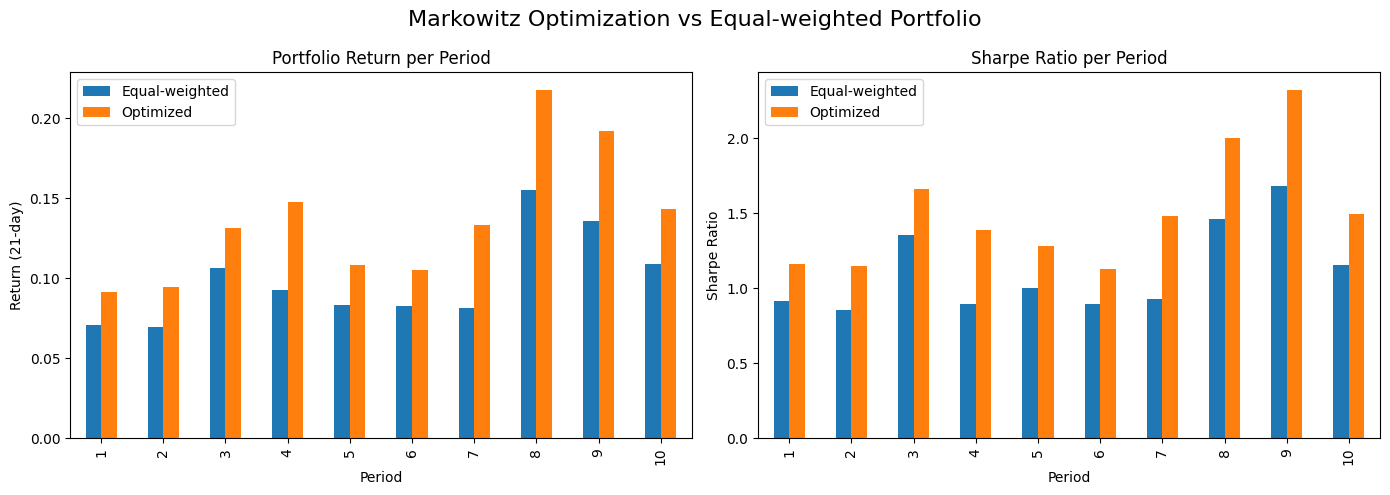

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# بازده
markowitz_df.plot(x="Period", y=["EqualW_Return","Opt_Return"], kind="bar", ax=axes[0])
axes[0].set_title("Portfolio Return per Period")
axes[0].set_ylabel("Return (21-day)")
axes[0].legend(["Equal-weighted","Optimized"])

# شارپ
markowitz_df.plot(x="Period", y=["EqualW_Sharpe","Opt_Sharpe"], kind="bar", ax=axes[1])
axes[1].set_title("Sharpe Ratio per Period")
axes[1].set_ylabel("Sharpe Ratio")
axes[1].legend(["Equal-weighted","Optimized"])

plt.suptitle("Markowitz Optimization vs Equal-weighted Portfolio", fontsize=16)
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_56992\3675444643.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', n_intervals)  # رنگ متفاوت برای هر بازه


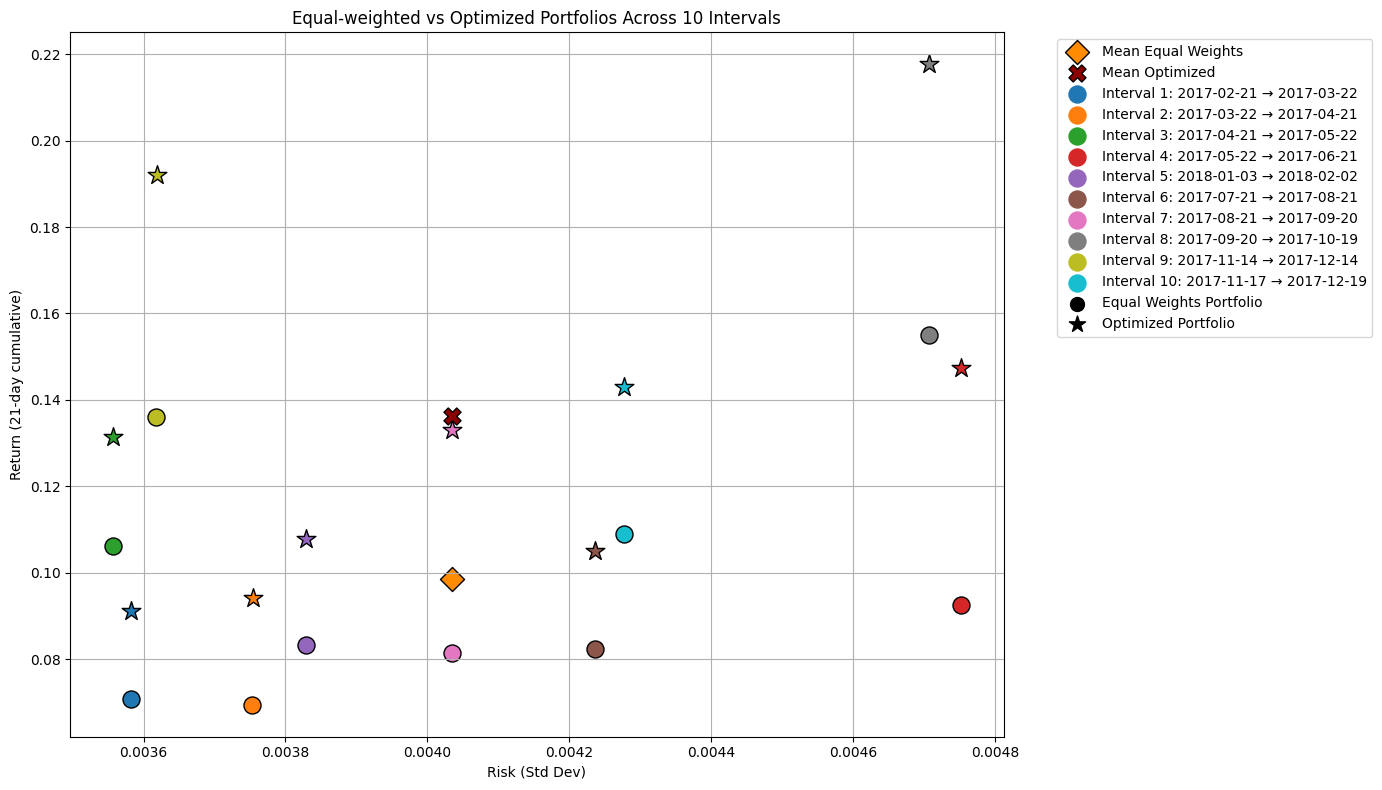


📊 Sharpe Ratio for Each Interval (from markowitz_df):
Interval 1: Equal Weights = 0.913, Optimized = 1.164
Interval 2: Equal Weights = 0.855, Optimized = 1.146
Interval 3: Equal Weights = 1.357, Optimized = 1.658
Interval 4: Equal Weights = 0.892, Optimized = 1.385
Interval 5: Equal Weights = 0.999, Optimized = 1.279
Interval 6: Equal Weights = 0.894, Optimized = 1.127
Interval 7: Equal Weights = 0.928, Optimized = 1.480
Interval 8: Equal Weights = 1.465, Optimized = 2.004
Interval 9: Equal Weights = 1.685, Optimized = 2.324
Interval 10: Equal Weights = 1.157, Optimized = 1.494


In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(14,8))

n_intervals = len(markowitz_df["Period"].unique())
colors = cm.get_cmap('tab10', n_intervals)  # رنگ متفاوت برای هر بازه

# ذخیره Sharpe برای چاپ
sharpe_info = []

for i, row in markowitz_df.iterrows():
    idx = int(row["Period"]) - 1
    
    # استفاده از Sharpe محاسبه‌شده در جدول
    sharpe_eq = row["EqualW_Sharpe"]
    sharpe_opt = row["Opt_Sharpe"]
    sharpe_info.append((row["Period"], sharpe_eq, sharpe_opt))
    
    # Equal Weights (دایره)
    plt.scatter(row["EqualW_Risk"], row["EqualW_Return"],
                color=colors(idx), s=150, edgecolor='k', marker='o')
    
    # Optimized Portfolio (ستاره)
    plt.scatter(row["Opt_Risk"], row["Opt_Return"],
                color=colors(idx), s=200, edgecolor='k', marker='*')

# نقاط میانگین کل بازه‌ها
mean_values = {
    "EqualW_Risk": markowitz_df["EqualW_Risk"].mean(),
    "EqualW_Return": markowitz_df["EqualW_Return"].mean(),
    "Opt_Risk": markowitz_df["Opt_Risk"].mean(),
    "Opt_Return": markowitz_df["Opt_Return"].mean()
}

plt.scatter(mean_values["EqualW_Risk"], mean_values["EqualW_Return"],
            c="darkorange", marker="D", s=150, label="Mean Equal Weights", edgecolor='k')
plt.scatter(mean_values["Opt_Risk"], mean_values["Opt_Return"],
            c="darkred", marker="X", s=150, label="Mean Optimized", edgecolor='k')

# Legend برای هر بازه با تاریخ‌ها
for i in range(n_intervals):
    interval_row = markowitz_df[markowitz_df["Period"] == i+1].iloc[0]
    start_date = interval_row["Start_Date"]
    end_date = interval_row["End_Date"]
    plt.scatter([], [], color=colors(i), s=150, 
                label=f"Interval {i+1}: {start_date} → {end_date}")

# توضیح نمادها
plt.scatter([], [], color='k', marker='o', s=100, label='Equal Weights Portfolio')
plt.scatter([], [], color='k', marker='*', s=150, label='Optimized Portfolio')

plt.xlabel("Risk (Std Dev)")
plt.ylabel("Return (21-day cumulative)")
plt.title("Equal-weighted vs Optimized Portfolios Across 10 Intervals")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# چاپ Sharpe Ratio برای هر بازه (از جدول نهایی)
# =========================
print("\n📊 Sharpe Ratio for Each Interval (from markowitz_df):")
for interval, s_eq, s_opt in sharpe_info:
    print(f"Interval {interval}: Equal Weights = {s_eq:.3f}, Optimized = {s_opt:.3f}")


In [39]:
from scipy.optimize import minimize

def max_sharpe_portfolio(mean_returns, cov_matrix, risk_free_rate=0.0):
    n = len(mean_returns)
    init_w = np.repeat(1/n, n)
    bounds = tuple((0, 1) for _ in range(n))
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

    def neg_sharpe(w):
        port_return = np.dot(w, mean_returns)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        return -(port_return - risk_free_rate) / port_vol  # ماکزیمم شارپ

    result = minimize(neg_sharpe, init_w, bounds=bounds, constraints=constraints)
    return result


In [40]:
markowitz_stats = []

for i in range(n_periods):
    subset = returns_df[returns_df["Period"] == i+1]
    top10 = subset["Stock"].tolist()
    
    # داده بازده روزانه این سهم‌ها
    daily_matrix = []
    for s in top10:
        dr = daily_returns[s][i*period:(i+1)*period]
        daily_matrix.append(dr)
    daily_matrix = np.array(daily_matrix).T
    
    mean_returns = np.mean(daily_matrix, axis=0)
    cov_matrix = np.cov(daily_matrix.T)
    
    # پرتفوی مساوی
    equal_w = np.repeat(1/len(top10), len(top10))
    eq_daily = daily_matrix @ equal_w
    eq_return = np.prod(1 + eq_daily) - 1
    eq_vol = np.std(eq_daily, ddof=1)
    eq_sharpe = np.mean(eq_daily) / eq_vol
    
    # پرتفوی بهینه (Max Sharpe)
    res = max_sharpe_portfolio(mean_returns, cov_matrix)
    if res.success:
        w_opt = res.x
        opt_daily = daily_matrix @ w_opt
        opt_return = np.prod(1 + opt_daily) - 1
        opt_vol = np.std(opt_daily, ddof=1)
        opt_sharpe = np.mean(opt_daily) / opt_vol
    
        markowitz_stats.append([
            i+1, subset["Start_Date"].iloc[0], subset["End_Date"].iloc[0],
            eq_return, eq_vol, eq_sharpe,
            opt_return, opt_vol, opt_sharpe
        ])

markowitz_df = pd.DataFrame(markowitz_stats,
    columns=["Period","Start_Date","End_Date",
             "EqualW_Return","EqualW_Risk","EqualW_Sharpe",
             "Opt_Return","Opt_Risk","Opt_Sharpe"])

print("📊 Max Sharpe Portfolio vs Equal-weighted Portfolio")
print(markowitz_df)


📊 Max Sharpe Portfolio vs Equal-weighted Portfolio
   Period  Start_Date    End_Date  EqualW_Return  EqualW_Risk  EqualW_Sharpe  \
0       1  2017-02-21  2017-03-22       0.070823     0.003582       0.912816   
1       2  2017-03-22  2017-04-21       0.069424     0.003753       0.854853   
2       3  2017-04-21  2017-05-22       0.106214     0.003556       1.356605   
3       4  2017-05-22  2017-06-21       0.092622     0.004752       0.891687   
4       5  2018-01-03  2018-02-02       0.083306     0.003829       0.998756   
5       6  2017-07-21  2017-08-21       0.082406     0.004236       0.893914   
6       7  2017-08-21  2017-09-20       0.081439     0.004035       0.927709   
7       8  2017-09-20  2017-10-19       0.154967     0.004708       1.464557   
8       9  2017-11-14  2017-12-14       0.135955     0.003618       1.684644   
9      10  2017-11-17  2017-12-19       0.109016     0.004277       1.156889   

   Opt_Return  Opt_Risk  Opt_Sharpe  
0    0.065264  0.001804    1.6

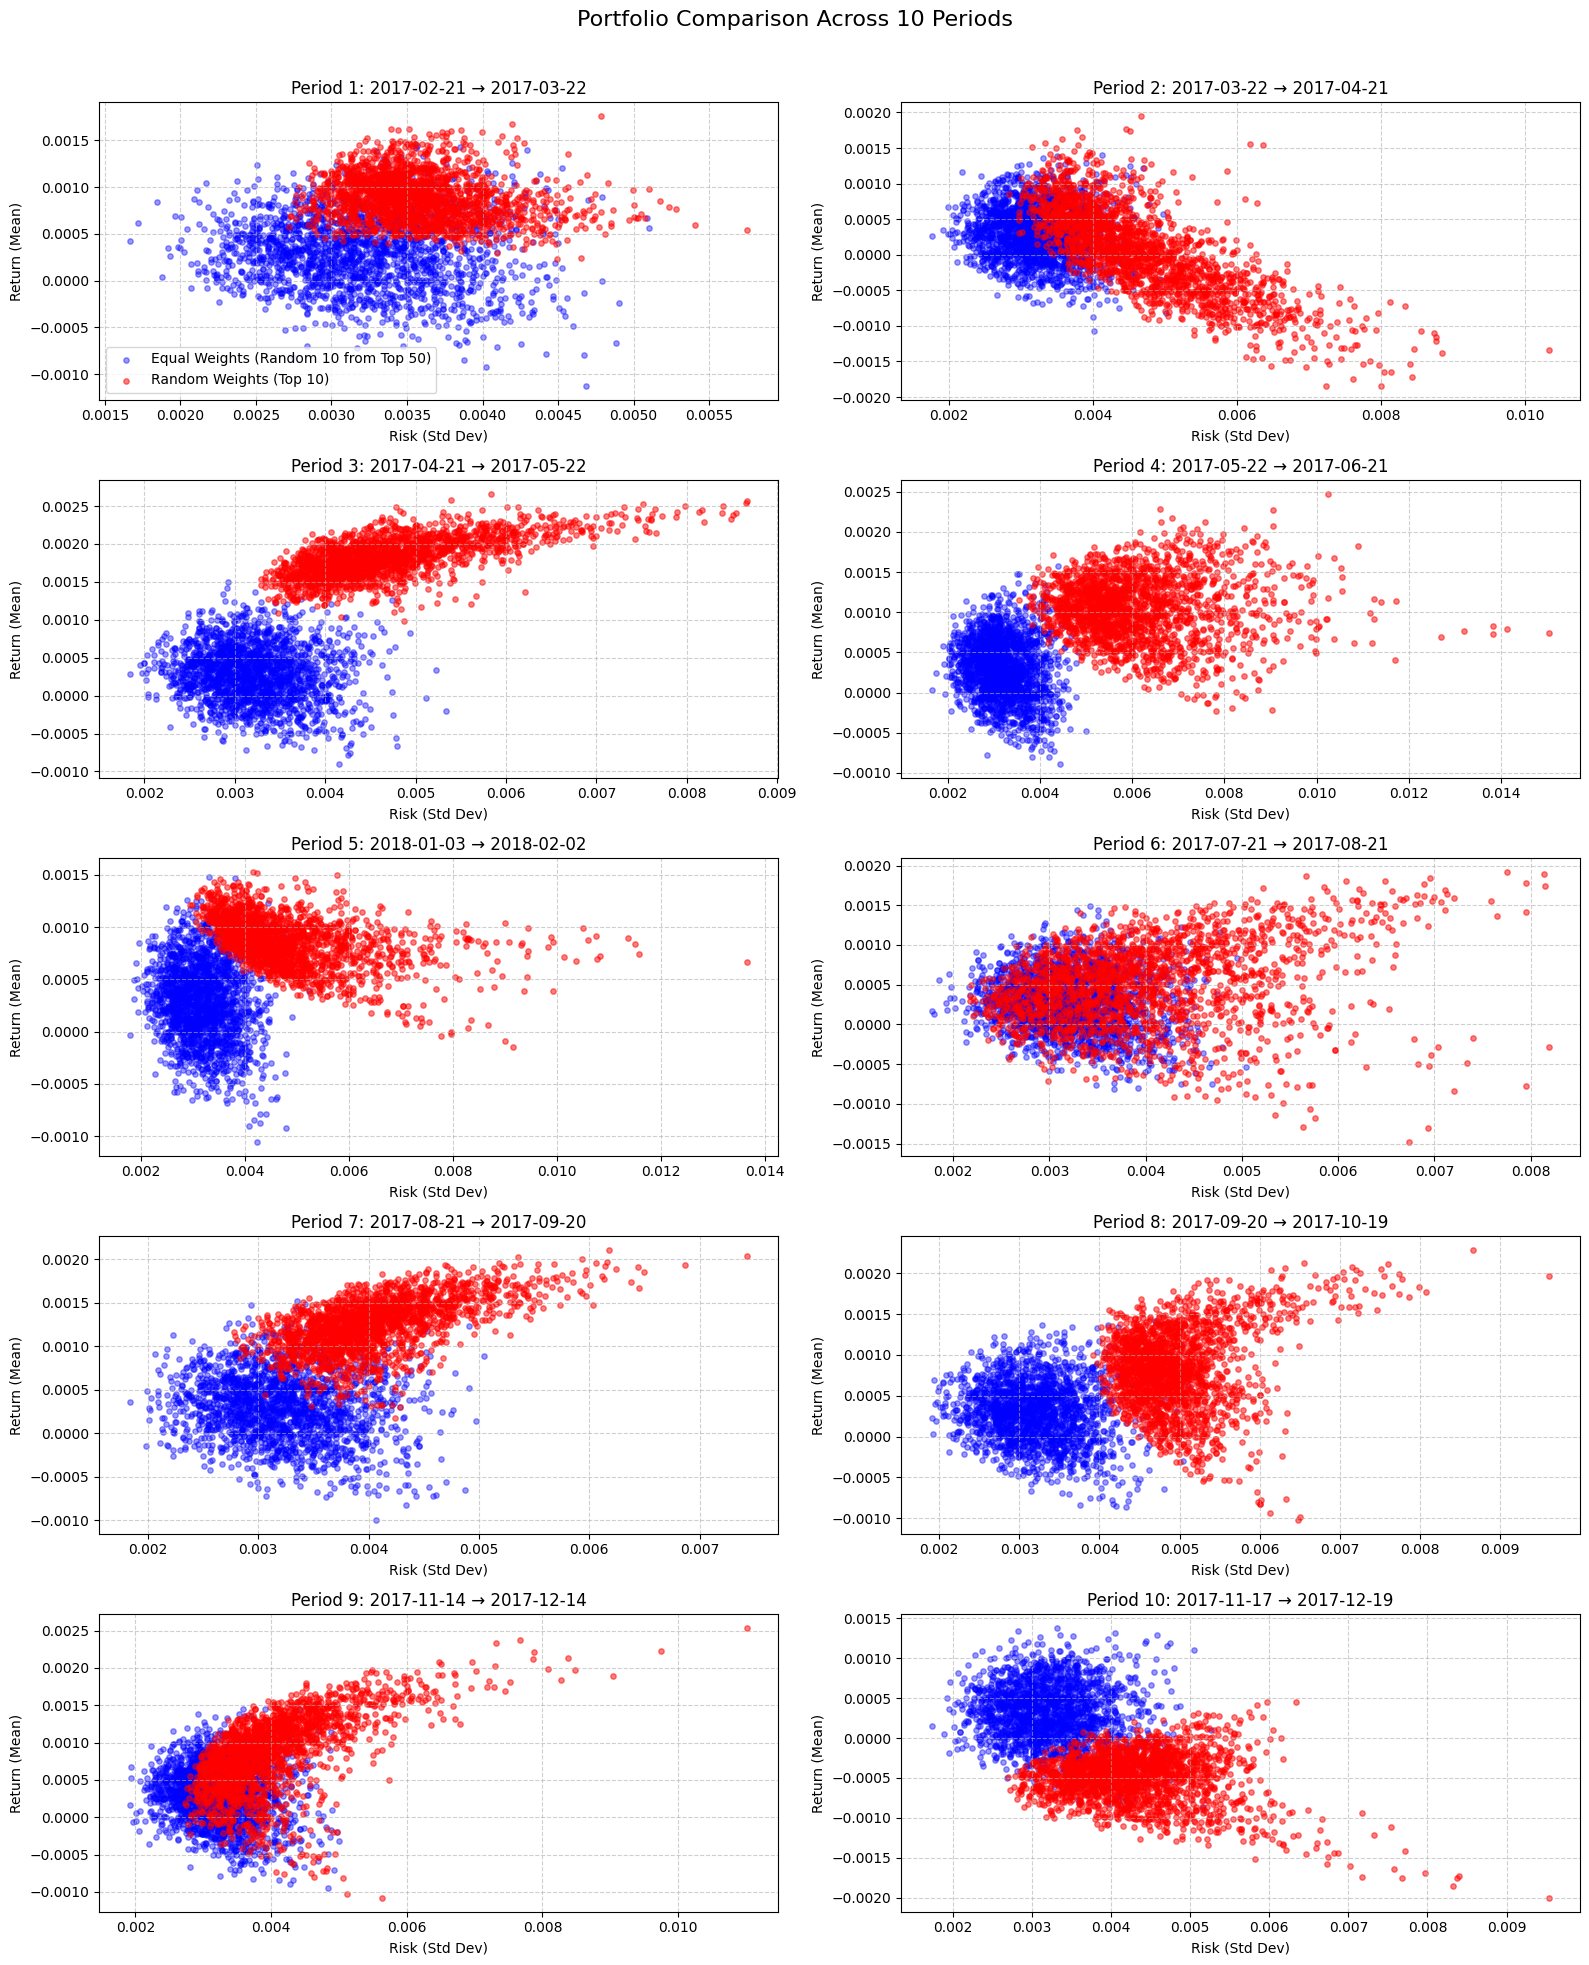

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# تابع محاسبه ریسک و بازده یک پرتفوی
def port_stats(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return ret, vol


# تنظیم نمودارها (۱۰ بازه = ۵×۲)
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

n_portfolios = 2000  # تعداد پرتفوی تصادفی در هر سری

for idx, row in enumerate(markowitz_df.itertuples()):
    period = row.Period
    start_date, end_date = row.Start_Date, row.End_Date
    
    # === آماده‌سازی داده‌ها ===
    subset = returns_df[returns_df["Period"] == period]
    top10 = subset["Stock"].tolist()
    
    # همه سری‌ها رو truncate می‌کنیم به طول یکسان
    min_len = min(len(v) for v in daily_returns.values())
    df_daily = pd.DataFrame({s: daily_returns[s][:min_len] for s in top50_stocks})
    
    df_50 = df_daily[top50_stocks]
    mean_returns_50 = df_50.mean().values
    cov_matrix_50 = df_50.cov().values
    
    df_10 = df_daily[top10]
    mean_returns_10 = df_10.mean().values
    cov_matrix_10 = df_10.cov().values
    
    # === سری اول (آبی: ۱۰ سهم رندوم از ۵۰ با وزن مساوی) ===
    rets_eq, vols_eq = [], []
    for _ in range(n_portfolios):
        chosen_idx = np.random.choice(len(top50_stocks), size=10, replace=False)
        chosen_returns = mean_returns_50[chosen_idx]
        chosen_cov = cov_matrix_50[np.ix_(chosen_idx, chosen_idx)]
        weights = np.ones(10) / 10
        r, v = port_stats(weights, chosen_returns, chosen_cov)
        rets_eq.append(r)
        vols_eq.append(v)
    
    # === سری دوم (قرمز: ۱۰ سهم برتر با وزن رندوم) ===
    rets_rnd, vols_rnd = [], []
    for _ in range(n_portfolios):
        weights = np.random.dirichlet(np.ones(len(top10)), size=1)[0]
        r, v = port_stats(weights, mean_returns_10, cov_matrix_10)
        rets_rnd.append(r)
        vols_rnd.append(v)
    
    # === رسم روی subplot ===
    axes[idx].scatter(vols_eq, rets_eq, c="blue", alpha=0.4, s=15,
                      label="Equal Weights (Random 10 from Top 50)")
    axes[idx].scatter(vols_rnd, rets_rnd, c="red", alpha=0.5, s=15,
                      label="Random Weights (Top 10)")
    
    axes[idx].set_title(f"Period {period}: {start_date} → {end_date}")
    axes[idx].set_xlabel("Risk (Std Dev)")
    axes[idx].set_ylabel("Return (Mean)")
    axes[idx].grid(True, linestyle="--", alpha=0.6)
    
    # فقط روی نمودار اول راهنما بزار
    if idx == 0:
        axes[idx].legend()

plt.suptitle("Portfolio Comparison Across 10 Periods", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


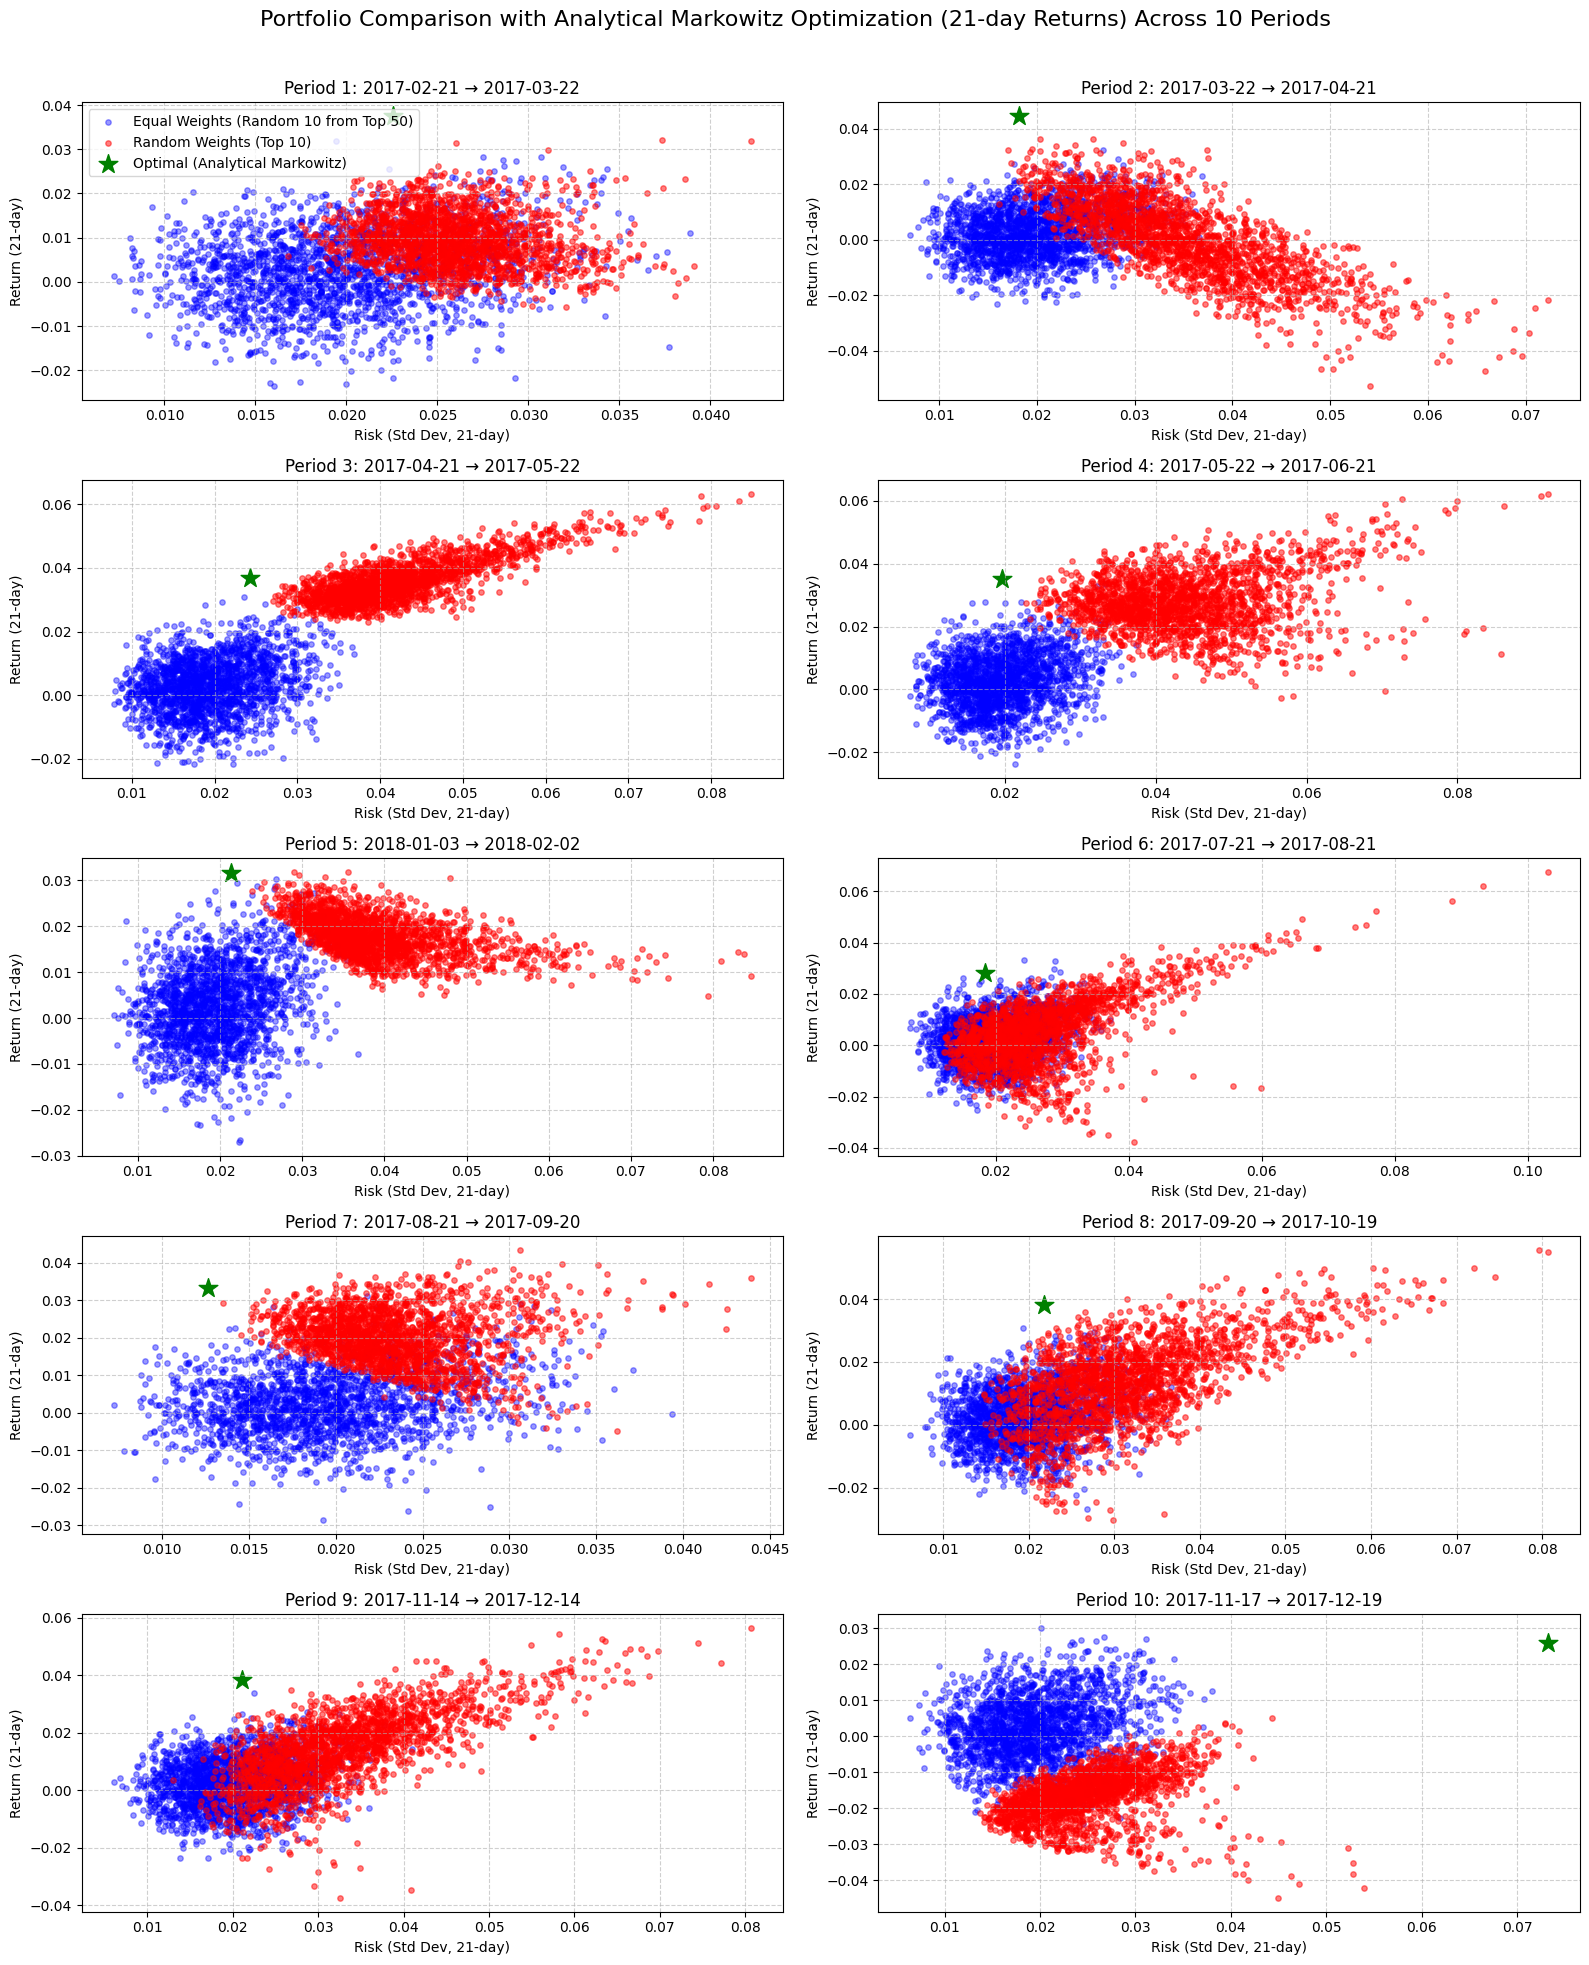

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- محاسبه بازده و ریسک یک پرتفوی ---
def port_stats(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return ret, vol

# --- تابع هدف = منفی Sharpe ---
def neg_sharpe(weights, mean_returns, cov_matrix):
    r, v = port_stats(weights, mean_returns, cov_matrix)
    return -r / v if v > 0 else 1e6

# --- بهینه‌سازی تحلیلی مارکویتز ---
def optimize_portfolio(mean_returns, cov_matrix):
    n_assets = len(mean_returns)
    init_w = np.ones(n_assets) / n_assets
    bounds = tuple((0, 1) for _ in range(n_assets))  # 0 ≤ w ≤ 1
    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    
    result = minimize(neg_sharpe, init_w,
                      args=(mean_returns, cov_matrix),
                      method="SLSQP", bounds=bounds, constraints=cons)
    
    opt_w = result.x
    opt_r, opt_v = port_stats(opt_w, mean_returns, cov_matrix)
    return opt_w, opt_r, opt_v

# ===========================
# رسم نمودار برای ۱۰ بازه
# ===========================
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

n_portfolios = 2000  # تعداد پرتفوی تصادفی

HORIZON = 21  # بازده ۲۱ روزه

for idx, row in enumerate(markowitz_df.itertuples()):
    period = row.Period
    start_date, end_date = row.Start_Date, row.End_Date
    
    # --- داده‌های بازه ---
    subset = returns_df[returns_df["Period"] == period]
    top10 = subset["Stock"].tolist()
    
    # هم‌طول کردن سری‌ها
    min_len = min(len(v) for v in daily_returns.values())
    df_daily = pd.DataFrame({s: daily_returns[s][:min_len] for s in top50_stocks})
    
    # --- بازده‌های rolling ۲۱ روزه ---
    df_50_21d = df_daily[top50_stocks].rolling(window=HORIZON).sum().dropna()
    df_10_21d = df_daily[top10].rolling(window=HORIZON).sum().dropna()
    
    mean_returns_50 = df_50_21d.mean().values
    cov_matrix_50 = df_50_21d.cov().values
    
    mean_returns_10 = df_10_21d.mean().values
    cov_matrix_10 = df_10_21d.cov().values
    
    # --- سری اول (آبی: ۱۰ سهم تصادفی از ۵۰ با وزن مساوی) ---
    rets_eq, vols_eq = [], []
    for _ in range(n_portfolios):
        chosen_idx = np.random.choice(len(top50_stocks), size=10, replace=False)
        chosen_returns = mean_returns_50[chosen_idx]
        chosen_cov = cov_matrix_50[np.ix_(chosen_idx, chosen_idx)]
        weights = np.ones(10) / 10
        r, v = port_stats(weights, chosen_returns, chosen_cov)
        rets_eq.append(r)
        vols_eq.append(v)
    
    # --- سری دوم (قرمز: ۱۰ سهم برتر با وزن رندوم) ---
    rets_rnd, vols_rnd = [], []
    for _ in range(n_portfolios):
        weights = np.random.dirichlet(np.ones(len(top10)), size=1)[0]
        r, v = port_stats(weights, mean_returns_10, cov_matrix_10)
        rets_rnd.append(r)
        vols_rnd.append(v)
    
    # --- پرتفوی بهینه (تحلیلی مارکویتز روی Top 10) ---
    opt_w, opt_r, opt_v = optimize_portfolio(mean_returns_10, cov_matrix_10)
    
    # --- رسم روی subplot ---
    axes[idx].scatter(vols_eq, rets_eq, c="blue", alpha=0.4, s=15,
                      label="Equal Weights (Random 10 from Top 50)")
    axes[idx].scatter(vols_rnd, rets_rnd, c="red", alpha=0.5, s=15,
                      label="Random Weights (Top 10)")
    axes[idx].scatter(opt_v, opt_r, c="green", marker="*", s=200,
                      label="Optimal (Analytical Markowitz)")
    
    axes[idx].set_title(f"Period {period}: {start_date} → {end_date}")
    axes[idx].set_xlabel("Risk (Std Dev, 21-day)")
    axes[idx].set_ylabel("Return (21-day)")
    axes[idx].grid(True, linestyle="--", alpha=0.6)
    
    if idx == 0:
        axes[idx].legend()

plt.suptitle("Portfolio Comparison with Analytical Markowitz Optimization (21-day Returns) Across 10 Periods", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


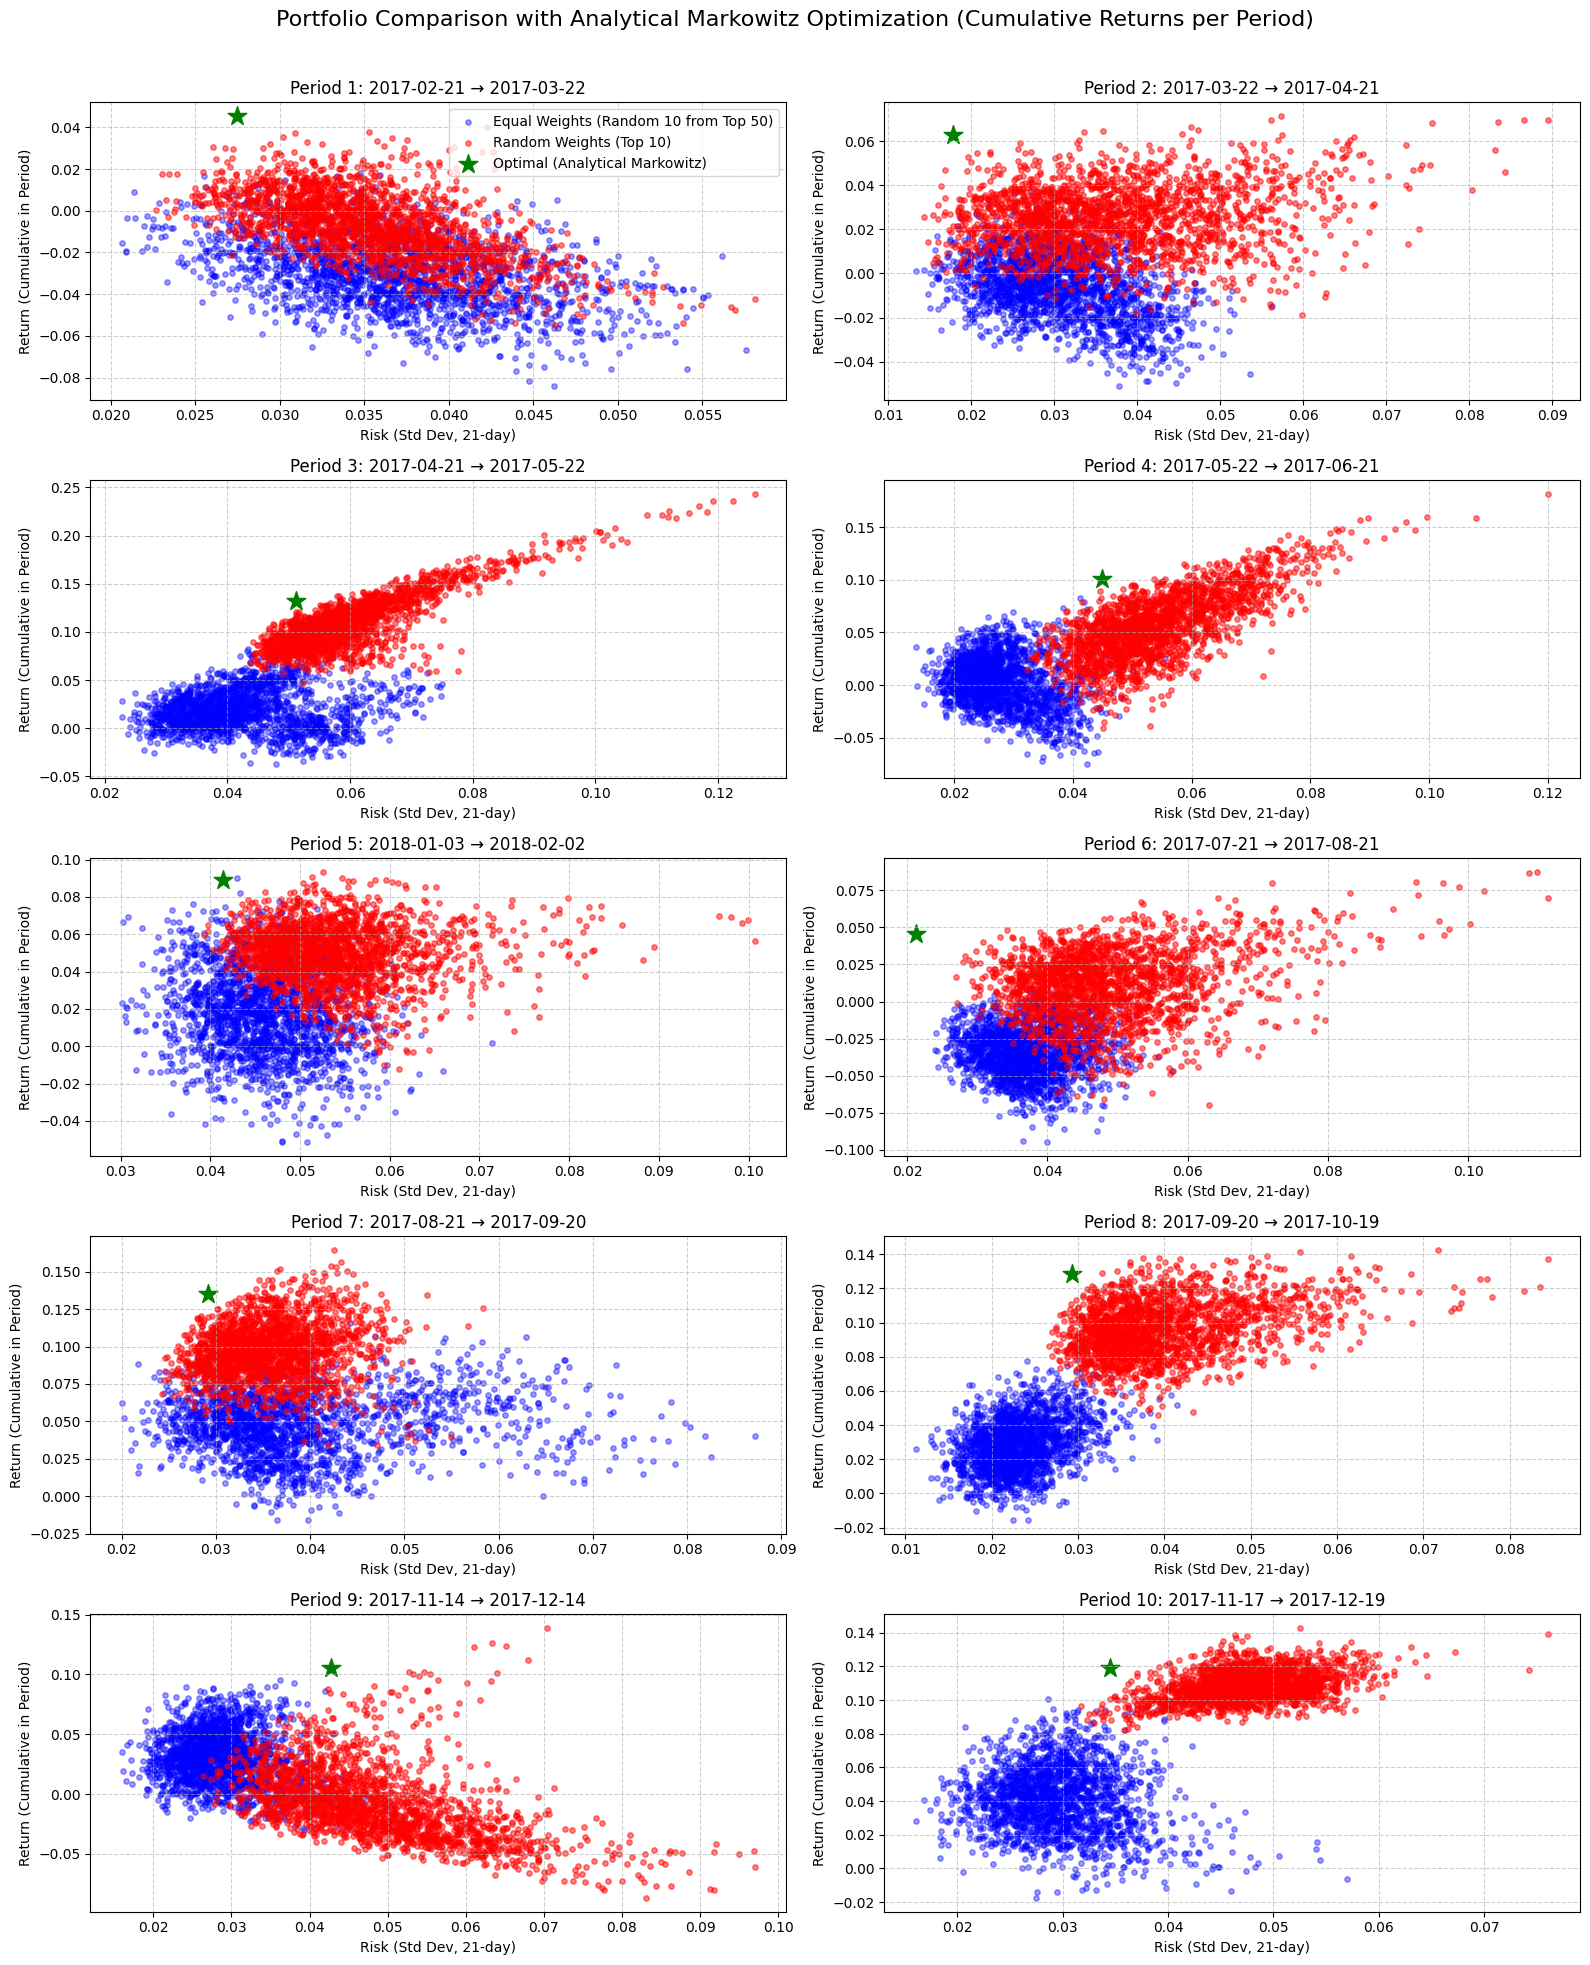

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- محاسبه بازده و ریسک یک پرتفوی ---
def port_stats(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return ret, vol

# --- تابع هدف = منفی Sharpe ---
def neg_sharpe(weights, mean_returns, cov_matrix):
    r, v = port_stats(weights, mean_returns, cov_matrix)
    return -r / v if v > 0 else 1e6

# --- بهینه‌سازی تحلیلی مارکویتز ---
def optimize_portfolio(mean_returns, cov_matrix):
    n_assets = len(mean_returns)
    init_w = np.ones(n_assets) / n_assets
    bounds = tuple((0, 1) for _ in range(n_assets))  # 0 ≤ w ≤ 1
    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    
    result = minimize(neg_sharpe, init_w,
                      args=(mean_returns, cov_matrix),
                      method="SLSQP", bounds=bounds, constraints=cons)
    
    opt_w = result.x
    opt_r, opt_v = port_stats(opt_w, mean_returns, cov_matrix)
    return opt_w, opt_r, opt_v

# ===========================
# رسم نمودار برای ۱۰ بازه
# ===========================
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

n_portfolios = 2000  # تعداد پرتفوی تصادفی
HORIZON = 21         # بازه ۲۱ روزه برای ریسک

for idx, row in enumerate(markowitz_df.itertuples()):
    period = row.Period
    start_date, end_date = row.Start_Date, row.End_Date
    
    # --- داده‌های بازه ---
    subset = returns_df[returns_df["Period"] == period]
    top10 = subset["Stock"].tolist()
    
    # قیمت‌ها برای سهم‌های انتخاب شده
    df_prices = df[df["Name"].isin(top10)].pivot(index="date", columns="Name", values="close")
    df_prices = df_prices.loc[start_date:end_date]
    
    # بازده روزانه
    df_returns = df_prices.pct_change().dropna()
    
    # بازده تجمعی در بازه (≈ 10 تا 20 درصد)
    cum_returns = (1 + df_returns).prod() - 1
    mean_returns_10 = cum_returns.values
    
    # ماتریس کوواریانس بازده روزانه (برای ریسک ۲۱ روزه)
    cov_matrix_10 = df_returns.cov().values * HORIZON
    
    # --- سری اول (آبی: ۱۰ سهم تصادفی از ۵۰ با وزن مساوی) ---
    rets_eq, vols_eq = [], []
    for _ in range(n_portfolios):
        chosen_idx = np.random.choice(len(top50_stocks), size=10, replace=False)
        
        df_prices_50 = df[df["Name"].isin([top50_stocks[i] for i in chosen_idx])] \
                         .pivot(index="date", columns="Name", values="close")
        df_prices_50 = df_prices_50.loc[start_date:end_date]
        
        df_returns_50 = df_prices_50.pct_change().dropna()
        
        cum_returns_50 = (1 + df_returns_50).prod() - 1
        chosen_returns = cum_returns_50.values
        chosen_cov = df_returns_50.cov().values * HORIZON
        
        weights = np.ones(10) / 10
        r, v = port_stats(weights, chosen_returns, chosen_cov)
        rets_eq.append(r)
        vols_eq.append(v)
    
    # --- سری دوم (قرمز: ۱۰ سهم برتر با وزن رندوم) ---
    rets_rnd, vols_rnd = [], []
    for _ in range(n_portfolios):
        weights = np.random.dirichlet(np.ones(len(top10)), size=1)[0]
        r, v = port_stats(weights, mean_returns_10, cov_matrix_10)
        rets_rnd.append(r)
        vols_rnd.append(v)
    
    # --- پرتفوی بهینه (تحلیلی مارکویتز روی Top 10) ---
    opt_w, opt_r, opt_v = optimize_portfolio(mean_returns_10, cov_matrix_10)
    
    # --- رسم روی subplot ---
    axes[idx].scatter(vols_eq, rets_eq, c="blue", alpha=0.4, s=15,
                      label="Equal Weights (Random 10 from Top 50)")
    axes[idx].scatter(vols_rnd, rets_rnd, c="red", alpha=0.5, s=15,
                      label="Random Weights (Top 10)")
    axes[idx].scatter(opt_v, opt_r, c="green", marker="*", s=200,
                      label="Optimal (Analytical Markowitz)")
    
    axes[idx].set_title(f"Period {period}: {start_date} → {end_date}")
    axes[idx].set_xlabel("Risk (Std Dev, 21-day)")
    axes[idx].set_ylabel("Return (Cumulative in Period)")
    axes[idx].grid(True, linestyle="--", alpha=0.6)
    
    if idx == 0:
        axes[idx].legend()

plt.suptitle("Portfolio Comparison with Analytical Markowitz Optimization (Cumulative Returns per Period)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
